<h1>Content<span class="tocSkip"></span></h1>
<div class="toc">
  <ul class="toc-item">
    <li>
      <span>
        <a href="#Prepare" data-toc-modified-id="Prepare-1">
          <span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation
        </a>
      </span>
    </li>
    <li>
      <span>
        <a href="#Training" data-toc-modified-id="Training-2">
          <span class="toc-item-num">2&nbsp;&nbsp;</span>Training
        </a>
      </span>
      <ul class="toc-item">
        <li>
          <span>
            <a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1">
              <span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression
            </a>
          </span>
        </li>
        <li>
          <span>
            <a href="#SGD" data-toc-modified-id="SGD-2.2">
              <span class="toc-item-num">2.2&nbsp;&nbsp;</span>SGD
            </a>
          </span>
        </li>
        <li>
          <span>
            <a href="#LinearSVC" data-toc-modified-id="LinearSVC-2.3">
              <span class="toc-item-num">2.3&nbsp;&nbsp;</span>LinearSVC
            </a>
          </span>
        </li>
        <li>
          <span>
            <a href="#Check-on-test-data" data-toc-modified-id="Check-on-test-data-2.4">
              <span class="toc-item-num">2.4&nbsp;&nbsp;</span>Check on test data
        </a>
      </span>
    </li>
  </ul>
</div>

# Project for Wikishop

Online store "Wikishop" launches a new service. Now users can edit and supplement product descriptions, just like in wiki communities. That is, clients propose their edits and comment on the changes of others. The store needs a tool that will look for toxic comments and submit them for moderation.

The project has trained a model that classifies comments into positive and negative ones with a value of the quality metric *F1* not less than 0.75.

## Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="nltk")

import spacy
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm.notebook import tqdm
tqdm.pandas()
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score 

import re

RANDOM_STATE = 42

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# data loading
df = pd.read_csv(r'datasets/12_toxic_comments.csv', index_col=0)

In [3]:
df.head(15)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


The text needs to be lemitized, the imbalance in the target category is visible

In [4]:
# Description function, checking for gaps and duplicates
def describe_columns(df):
    
    values = pd.DataFrame()
    
    for col in df.columns:
        values[col] = [df[col].unique(), df[col].dtypes, df[col].nunique(), df[col].isnull().sum().sum(), df. duplicated().sum()]
        
    return values.transpose().sort_values(by=1, ascending=False).rename(
        {0: 'Values', 1: 'Data type', 2: 'Unique values', 3: 'Missing', 4: 'Duplicates'}, axis=1)

describe_columns(df)

,Values,Data type,Unique values,Missing,Duplicates
text,[Explanation\nWhy the edits made under my user...,object,159292,0,0
toxic,"[0, 1]",int64,2,0,0


Everything is ok with the data, there are no gaps and duplicates

In [5]:
nlp = spacy.load("en_core_web_sm")

In [6]:
# cleanup function and text lemitization
def lemm(text):
    doc = nlp(text) 
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha] # keep only alphabetic tokens
    clean_text = ' '.join(tokens)
    return clean_text

In [7]:
def clean(text):
    text = re.sub(r'\W', ' ', text) # remove non-alphanumeric characters
    text = re.sub(r'\d', ' ', text) # remove digits
    text = re.sub(r'\s+', ' ', text) # remove extra whitespaces
    return text.strip().lower() # convert to lowercase and remove leading/trailing whitespaces

In [8]:
df_good = df

In [9]:
df_good['text_good'] = df_good['text'].progress_apply(lemm)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [10]:
df_good['text_good'] = df_good['text_good'].progress_apply(clean)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [11]:
df_good

,text,toxic,text_good
0,Explanation\nWhy the edits made under my usern...,0,explanation edit username hardcore metallica f...
1,D'aww! He matches this background colour I'm s...,0,match background colour seemingly stick thank ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man try edit war guy constantly remove rel...
3,"""\nMore\nI can't make any real suggestions on ...",0,real suggestion improvement wonder section sta...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
...,...,...,...
159446,""":::::And for the second time of asking, when ...",0,second time asking view completely contradict ...
159447,You should be ashamed of yourself \n\nThat is ...,0,ashamed horrible thing talk page
159448,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm s actual article prostitution ring...
159449,And it looks like it was actually you who put ...,0,look like actually speedy version delete look


In [12]:
df_clean = df_good

In [13]:
df_clean = df_clean.drop('text', axis=1)

Data cleaned and lemmitized

In [14]:
df_fin = df_clean

In [15]:
# divide into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_fin['text_good'], df_fin['toxic'], 
                                                              test_size=0.25, random_state=12345, 
                                                              stratify=df_fin['toxic'])

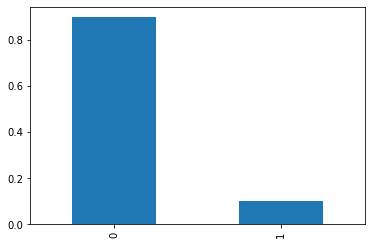

In [16]:
y_train.value_counts(normalize = (0,1)).plot(kind = 'bar')
plt.show()

In [17]:
# function upsample
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
    return features_upsampled, target_upsampled
# Upsample the training data
X_train_upsampled, y_train_upsampled = upsample(X_train, y_train, repeat=5)

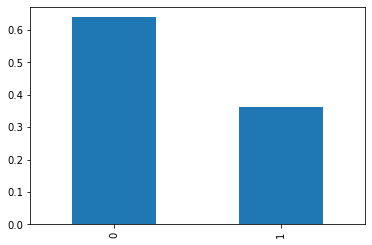

In [18]:
y_train_upsampled.value_counts(normalize = (0,1)).plot(kind = 'bar')
plt.show()

In [19]:
#check shapes
X_train_upsampled.shape

(168029,)

In [20]:
y_train_upsampled.shape

(168029,)

Data prepared for model training

Disbalance removed.

## Training

Text categorization in Python is typically done using machine learning models based on classification methods. Depending on specific requirements, you can choose from several algorithms, such as:

- Naive Bayes: This is a simple classification algorithm based on Bayes' theorem and is used for text classification tasks. It works well for text categorization tasks with a large number of categories.

- Logistic Regression: This classification method uses a linear combination of features to predict category labels. Logistic regression can be used for text categorization tasks.

- Support Vector Machines (SVM): This algorithm finds an optimal separating hyperplane between two classes. SVM can be used for text categorization tasks, especially for datasets with two classes.

- Random Forest: This is an ensemble method that combines multiple decision trees to obtain a more accurate result. Random Forest can be used for text categorization, especially when the dataset has many features.

Of these models, we will consider Logistic Regression and Support Vector Machines. We discard the naive Bayens method because of the specifics of the method, which is aimed at problems with a large number of categorizations. Random Forest due to too long training time.

### LogisticRegression

In [21]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', LogisticRegression(solver='liblinear', random_state=42))
])

params = {
    'vectorizer__max_features': [1000, 5000, 10000],
    'model__C': [0.1, 1, 10],
    'model__penalty': ['l1', 'l2']
}

gs_lr = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='f1', n_jobs=-1, error_score='raise')
gs_lr.fit(X_train_upsampled, y_train_upsampled)

print("Best parameters found:", gs_lr.best_params_)
print("Training F1 score:", gs_lr.best_score_)

# Evaluate on test data
y_pred_test = gs_lr.predict(X_test)
f1_score_test = f1_score(y_test, y_pred_test)
print("Test F1 score:", f1_score_test)

Best parameters found: {'model__C': 10, 'model__penalty': 'l1', 'vectorizer__max_features': 10000}
Training F1 score: 0.9351914389986608
Test F1 score: 0.7367703838292073


### SGD

In [22]:

pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', SGDClassifier(random_state=42))
])

params = {
    'vectorizer__max_features': [1000, 5000, 10000],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__penalty': ['l1', 'l2']
}

gs_sgd = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='f1', n_jobs=-1, error_score='raise')
gs_sgd.fit(X_train_upsampled, y_train_upsampled)

print("Best parameters found:", gs_sgd.best_params_)
print("Training F1 score:", gs_sgd.best_score_)

# Evaluate on test data
y_pred_test = gs_sgd.predict(X_test)
f1_score_test = f1_score(y_test, y_pred_test)
print("Test F1 score:", f1_score_test)

Best parameters found: {'model__alpha': 0.0001, 'model__penalty': 'l2', 'vectorizer__max_features': 10000}
Training F1 score: 0.8633803407602023
Test F1 score: 0.7744342203431983


### LinearSVC

In [23]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', LinearSVC(random_state=42))
])

params = {
    'vectorizer__max_features': [1000, 5000, 10000],
    'model__C': [0.1, 1, 10]
}

gs_linear_svc = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='f1', n_jobs=-1, error_score='raise')
gs_linear_svc.fit(X_train_upsampled, y_train_upsampled)

print("Best parameters found:", gs_linear_svc.best_params_)
print("Training F1 score:", gs_linear_svc.best_score_)

# Evaluate on test data
y_pred_test = gs_linear_svc.predict(X_test)
f1_score_test = f1_score(y_test, y_pred_test)
print("Test F1 score:", f1_score_test)

Best parameters found: {'model__C': 10, 'vectorizer__max_features': 10000}
Training F1 score: 0.9320429372523579
Test F1 score: 0.7219215155615697


LinearSVC showed the best result.

### Validation on test data

In [24]:
# Evaluate on test data
y_pred_test = gs_sgd.predict(X_test)
f1_score_test = f1_score(y_test, y_pred_test)
print("Test F1 score:", f1_score_test)

Test F1 score: 0.7744342203431983


The model shows a good result. It is this model that is recommended to be transferred to the customer.

## Сonclusions

To complete the task, it was necessary to balance the classes, and also carried out data lemitization. We considered models suitable for our tasks - Linear Regression, SGD and SVC, using the enumeration of parameters using the GridSearch method along with pipline.

We determined the best model that meets the requirements for the F1-score metric, with a quality of at least 0.75.